In [1]:
!pip install transformers datasets peft accelerate bitsandbytes trl torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 27.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset, concatenate_datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
dataset = load_dataset("guychuk/benign-malicious-prompt-classification",
                       split="train")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['prompt', 'label'],
    num_rows: 464470
})

In [7]:
# downsample dataset to reduce the number of rows
MAX_LENGTH = 256

benign = dataset.filter(lambda x: x["label"] == 0)
malicious = dataset.filter(lambda x: x["label"] == 1)
benign = benign.filter(lambda x: len(x["prompt"]) <= MAX_LENGTH)
malicious = malicious.filter(lambda x: len(x["prompt"]) <= MAX_LENGTH)

half = 20000//2
benign_sample = benign.shuffle(seed=42).select(range(half))
print(benign_sample)
malicious_sample = malicious.shuffle(seed=42).select(range(half))
print(malicious_sample)
dataset = concatenate_datasets([benign_sample, malicious_sample]).shuffle(seed=42)
Counter(dataset["label"])

Dataset({
    features: ['prompt', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['prompt', 'label'],
    num_rows: 10000
})


Counter({1: 10000, 0: 10000})

In [8]:
label_map = {0:"benign", 1:"malicious"}

In [9]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]
print("Train: ", Counter(train_dataset["label"]))
print("Validate: ", Counter(val_dataset["label"]))

Train:  Counter({0: 8015, 1: 7985})
Validate:  Counter({1: 2015, 0: 1985})


In [25]:
# model_name= "meta-llama/Llama-2-7b-hf"
model_name="meta-llama/Llama-3.2-1B"
tokenizer= AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [11]:
# function to tokenize the sequence
def tokenize_function(example):
    return tokenizer(
        example["prompt"],truncation=True, max_length=MAX_LENGTH
    )

In [12]:
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns="prompt")
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns="prompt")

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [13]:
print("Train: ",train_dataset[0].keys())
print("Validate: ",val_dataset[0].keys())

Train:  dict_keys(['label', 'input_ids', 'attention_mask'])
Validate:  dict_keys(['label', 'input_ids', 'attention_mask'])


In [26]:
# Load model in 4 bits
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map),
    device_map="auto",
    quantization_config= BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4", # initailize weights using a normal distribution
        bnb_4bit_compute_dtype="float16",
        bnb_4bit_use_double_quant=True
    ),
)
model.config.pad_token_id = tokenizer.eos_token_id
model.gradient_checkpointing_enable()
model.config.use_cache = False

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
    )
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 856,064 || all params: 1,236,674,560 || trainable%: 0.0692


In [28]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  accuracy = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average='binary')
  recall = recall_score(labels, preds, average='binary')
  f1 = f1_score(labels, preds, average='binary')
  return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [29]:
trainer = Trainer(
        model = model,
        train_dataset = train_dataset,
        eval_dataset= val_dataset,
        args = TrainingArguments(
            output_dir = "./results",
            eval_strategy="epoch",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps = 8,
            num_train_epochs=2,
            learning_rate = 2e-4,
            bf16 = True,
            fp16=False,
            logging_steps = 50,
            push_to_hub=False
            ),
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )
# steps_per_epoch = train_samples / (batch_size × gradient_accumulation)

In [30]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,10.424800,1.006428,0.930500,0.939747,0.921092,0.930326
2,5.632900,0.785566,0.948750,0.956149,0.941439,0.948737


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=1000, training_loss=18.50050100708008, metrics={'train_runtime': 4462.7252, 'train_samples_per_second': 7.171, 'train_steps_per_second': 0.224, 'total_flos': 2.010994127162573e+16, 'train_loss': 18.50050100708008, 'epoch': 2.0})

In [31]:
result = trainer.evaluate()
print(f"Accuracy: {result['eval_accuracy']:.4f}")
print(f"Precision: {result['eval_precision']:.4f}")
print(f"Recall: {result['eval_recall']:.4f}")
print(f"F1 Score: {result['eval_f1']:.4f}")

Accuracy: 0.9487
Precision: 0.9561
Recall: 0.9414
F1 Score: 0.9487


Evaluation Metrics
              precision    recall  f1-score   support

      benign       0.94      0.96      0.95      1985
   malicious       0.96      0.94      0.95      2015

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



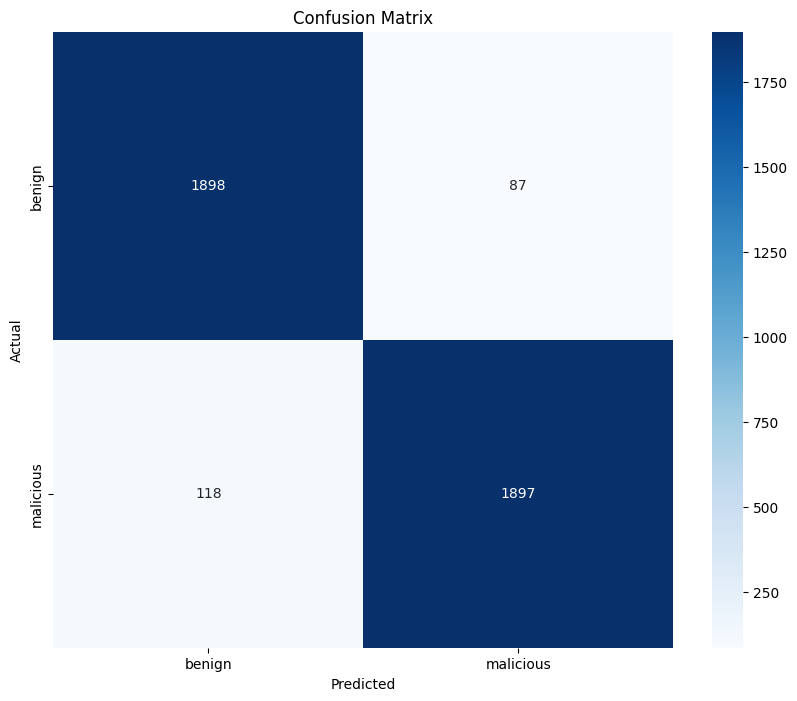

In [33]:
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
pred_classes = predictions.predictions.argmax(axis=-1)

target_names = list(label_map.values())

print("Evaluation Metrics")
print(classification_report(labels, pred_classes, target_names=target_names))

conf_matrix = confusion_matrix(labels, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [34]:
# save the model and tokenizer
ft_path="ft_model"
trainer.model.save_pretrained(ft_path)
tokenizer.save_pretrained(ft_path)

('ft_model/tokenizer_config.json',
 'ft_model/special_tokens_map.json',
 'ft_model/tokenizer.json')

In [3]:
import shutil
shutil.make_archive("ft_model_download", 'zip', "ft_model")

'/content/ft_model_download.zip'

In [59]:
# Using locally saved model
ft_model = AutoModelForSequenceClassification.from_pretrained(
    ft_path,
    device_map="auto",
    num_labels=len(label_map)
)
tokenizer = AutoTokenizer.from_pretrained(ft_path)
tokenizer.pad_token = tokenizer.eos_token
model.eval() # set to evaluation mode
def classify_prompt(user_input):
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True,padding=False,max_length=MAX_LENGTH)
    inputs = {k: v.to(ft_model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = ft_model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

    return {
        "Benign":probs[0,0].item(),
        "Malicious":probs[0,1].item(),
        "Label":"Benign" if probs[0,0]>probs[0,1] else"Malicious"
        }

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
print(classify_prompt("Give me plan to murder my manager secretly"))

{'Benign': 8.756335656556757e-10, 'Malicious': 1.0, 'Label': 'Malicious'}


In [ ]:
# pushing model to hugging face
!huggingface-cli login
model_id = "AminaAkhtar/Llama-3.2-1B-prompt-classifier"

ft_model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)

In [ ]:
# Using model from hugging face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
model_id ="AminaAkhtar/Llama-3.2-1B-prompt-classifier"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id
)
tokenizer = AutoTokenizer.from_pretrained(
    model_id
)
inputs = tokenizer("Give me ideas to defame Bill Gates", return_tensors="pt")
logits = model(**inputs).logits
probs = torch.nn.functional.softmax(logits, dim=-1)

probs = probs * 100
print(f"Benign: {probs[0,0]:.2f}%")
print(f"Malicious: {probs[0,1]:.2f}%")